## Import library

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import yaml
import re
import matplotlib.pyplot as plt
import os
os.chdir("NLP_ENSAE_Project/")
os.getcwd()

pd.set_option('future.no_silent_downcasting', True)

## Load data and tokens

In [2]:
!cd NLP_ENSAE_Project
with open(f'data/entities.json', 'r') as file:
    data = json.load(file)

with open(f'data/tokens.yml', 'r') as file:
    tokens = yaml.safe_load(file)
    
token_dict = {}
for col in tokens.keys():
    token = tokens[col]['start']
    token_dict[token] = col

token_dict

/bin/bash: line 1: cd: NLP_ENSAE_Project: No such file or directory


{'Ⓐ': 'age',
 'Ⓑ': 'birth_date',
 'Ⓒ': 'civil_status',
 'Ⓓ': 'education_level',
 'Ⓔ': 'employer',
 'Ⓕ': 'firstname',
 'Ⓗ': 'link',
 'Ⓘ': 'lob',
 'Ⓙ': 'maiden_name',
 'Ⓚ': 'nationality',
 'Ⓛ': 'observation',
 'Ⓜ': 'occupation',
 'Ⓞ': 'surname',
 'Ⓟ': 'surname_household'}

In [3]:
## Some Useful functions in my own .py

In [4]:
from src.useful_functions import *

## Preprocessing

In [5]:
df = get_preprocessing_done(data, tokens,  token_dict)
df = df.rename(columns={"surname_household": "Is_household"})
X = df.drop(columns=['Is_household'])
y = df['Is_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )

100%|██████████| 1218/1218 [00:00<00:00, 2660.58it/s]


In [6]:
X

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25433,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN
25434,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,idem,NaN,ouv chaus res,NaN
25435,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN
25436,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti


In [7]:
y

0        0
1        1
2        1
3        1
4        0
        ..
25433    1
25434    1
25435    1
25436    0
25437    0
Name: Is_household, Length: 25074, dtype: int64

## Antoine

## Avec Surname

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import time

In [9]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y, test_size=0.20, stratify=y)

In [10]:
description_features_string = [
    'civil_status',
    'education_level',
    'employer',
    'firstname',
    'link',
    'lob',
    'maiden_name',
    'nationality',
    'observation',
    'occupation',
    'surname'
]
description_features_num = [
    'age',
    'birth_date'
]
target_features = ['Is_household']

In [11]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [
        (
            "string",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_string,
        )
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("scaler", StandardScaler()),
    ]
)
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(class_weight='balanced',random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 1.781s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Inference Time: 0.178s
Notre accuracy de test est de : 0.8408773678963111
Classification report
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      3887
           1       0.59      0.97      0.73      1128

    accuracy                           0.84      5015
   macro avg       0.79      0.89      0.81      5015
weighted avg       0.90      0.84      0.85      5015



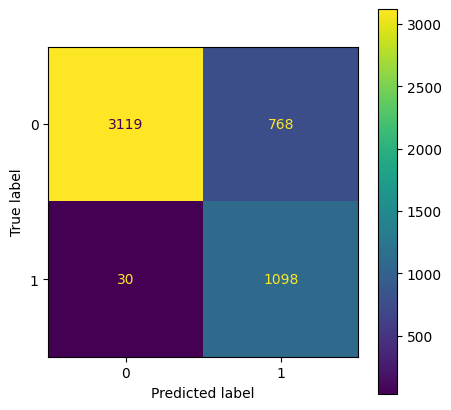

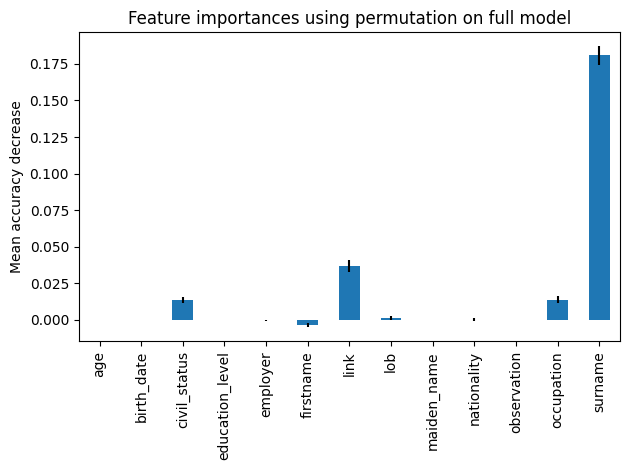

In [12]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [13]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", BalancedRandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Training time: 1.554s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 BalancedRandomForestClassifier(random_state=42))])

Inference Time: 0.207s
Notre accuracy de test est de : 0.7944167497507477
Classification report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      3887
           1       0.52      1.00      0.69      1128

    accuracy                           0.79      5015
   macro avg       0.76      0.87      0.77      5015
weighted avg       0.89      0.79      0.81      5015



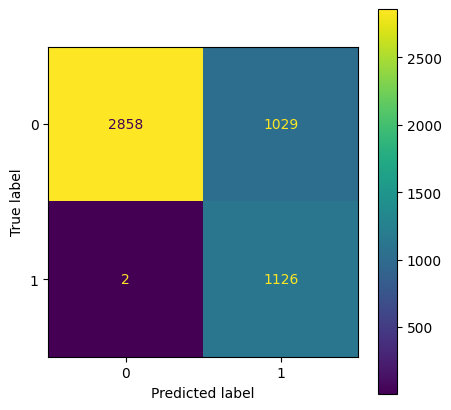

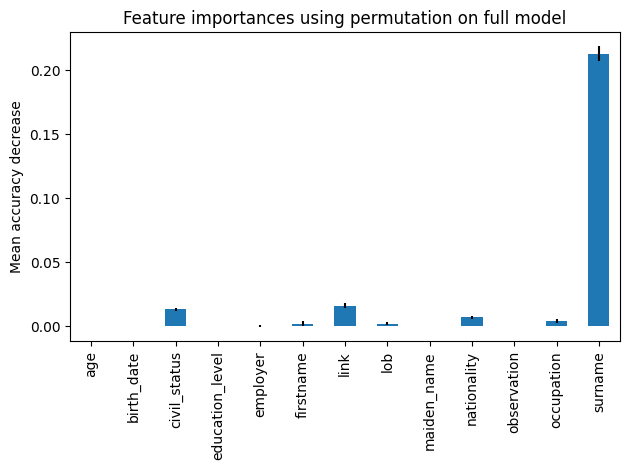

In [14]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [15]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", HistGradientBoostingClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 0.731s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation',
                                                   'surname'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

Inference Time: 0.147s
Notre accuracy de test est de : 0.8305084745762712
Classification report
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3887
           1       0.57      0.97      0.72      1128

    accuracy                           0.83      5015
   macro avg       0.78      0.88      0.80      5015
weighted avg       0.90      0.83      0.84      5015



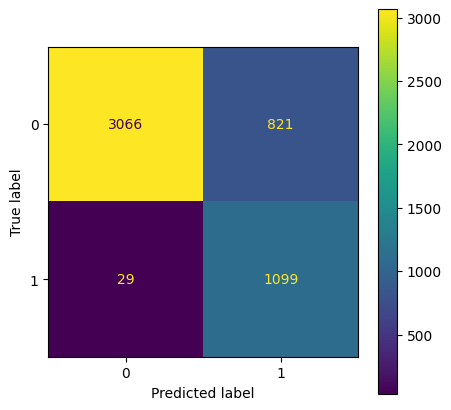

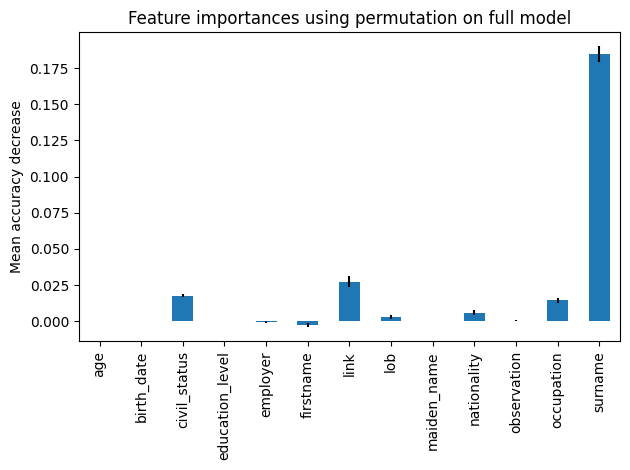

In [16]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

## Sans surname

In [17]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X.drop(['surname'], axis = 1), y, test_size=0.20, stratify=y)
description_features_string = [
    'civil_status',
    'education_level',
    'employer',
    'firstname',
    'link',
    'lob',
    'maiden_name',
    'nationality',
    'observation',
    'occupation'
]

In [18]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [
        (
            "string",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_string,
        )
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("scaler", StandardScaler()),
    ]
)
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 2.549s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=42))])

Inference Time: 0.214s
Notre accuracy de test est de : 0.9158524426719841
Classification report
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3887
           1       0.80      0.83      0.82      1128

    accuracy                           0.92      5015
   macro avg       0.88      0.89      0.88      5015
weighted avg       0.92      0.92      0.92      5015



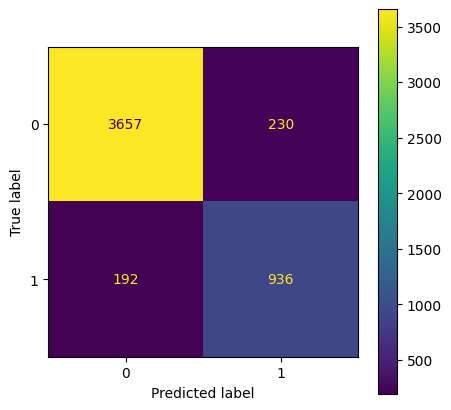

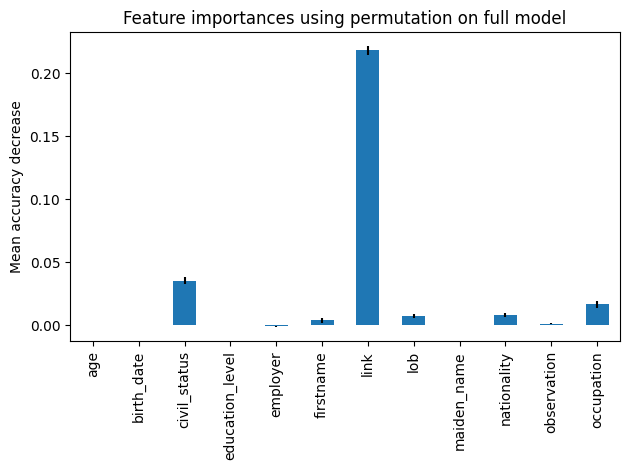

In [19]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [20]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", BalancedRandomForestClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/mamba/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Training time: 1.798s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 BalancedRandomForestClassifier(random_state=42))])

Inference Time: 0.218s
Notre accuracy de test est de : 0.9168494516450648
Classification report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3887
           1       0.75      0.94      0.84      1128

    accuracy                           0.92      5015
   macro avg       0.87      0.93      0.89      5015
weighted avg       0.93      0.92      0.92      5015



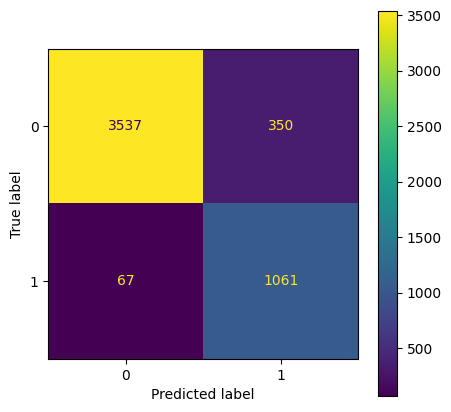

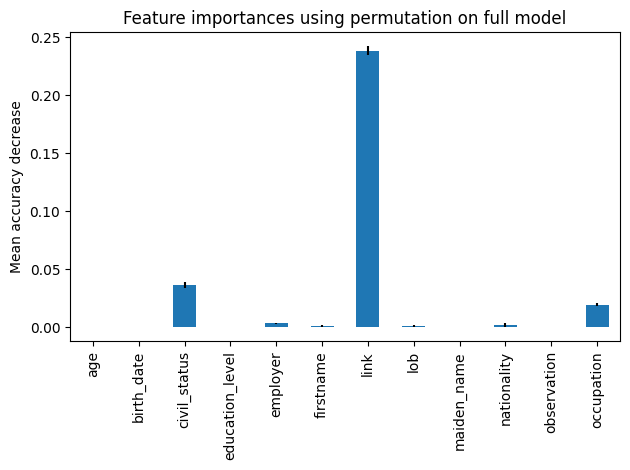

In [21]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

In [22]:
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", HistGradientBoostingClassifier(random_state=42)),
    ]
)
start = time.time()
clf.fit(X_train_enc, y_train_enc)
stop = time.time()
print(f"Training time: {round(stop - start,3)}s")
clf

Training time: 0.81s


Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['civil_status',
                                                   'education_level',
                                                   'employer', 'firstname',
                                                   'link', 'lob', 'maiden_name',
                                                   'nationality', 'observation',
                                                   'occupation'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=-1,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

Inference Time: 0.122s
Notre accuracy de test est de : 0.9280159521435692
Classification report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3887
           1       0.81      0.89      0.85      1128

    accuracy                           0.93      5015
   macro avg       0.89      0.92      0.90      5015
weighted avg       0.93      0.93      0.93      5015



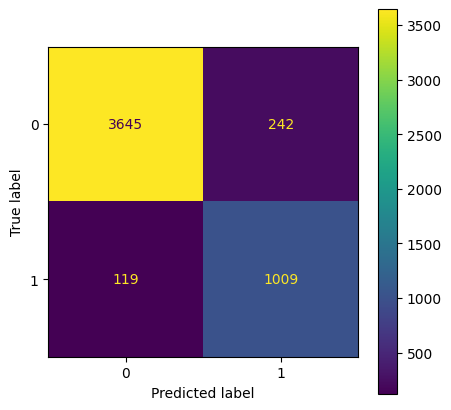

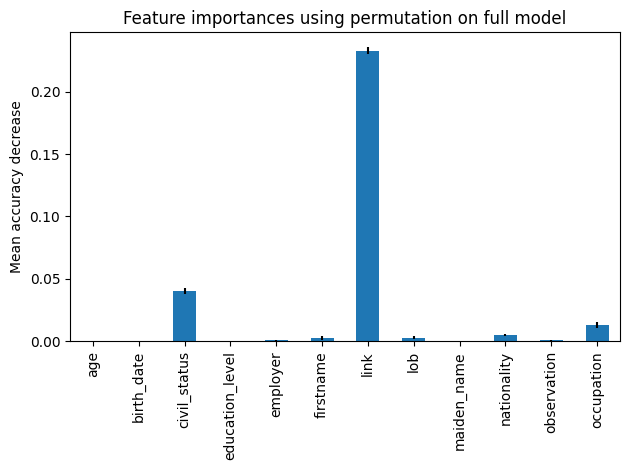

In [23]:
get_report(clf, X_train_enc, X_test_enc, y_train_enc, y_test_enc, description_features_string, description_features_num, target_features)

## Gradient Boosting

In [24]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import log_loss

#### Ordinal Encoding

In [25]:
enc = OrdinalEncoder()
X_encoded = enc.fit_transform(X)

In [26]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.20, stratify=y)

### Gradient Boosting

In [ ]:
param_grid = {
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "max_leaf_nodes": [15, 31, 100],
    "max_depth": [None, 5, 10, 20],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0]
}

model = HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, class_weight='balanced', validation_fraction=0.2)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)

grid_search.fit(X_train_enc, y_train_enc)

In [12]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 10}


In [13]:
# Get the best model from the grid search
clf = grid_search.best_estimator_
clf.fit(X_train_enc, y_train_enc)

HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               max_depth=10, max_iter=10000, max_leaf_nodes=100,
                               min_samples_leaf=10, validation_fraction=0.2)

In [14]:
print(f"Train accuracy: {clf.score(X_train_enc, y_train_enc):.3f}")
print(f"Test accuracy: {clf.score(X_test_enc, y_test_enc):.3f}")

Train accuracy: 0.999
Test accuracy: 0.996


In [15]:
print(f'Train CE loss = {log_loss(y_train_enc, clf.predict_proba(X_train_enc)):.4f}')
print(f'Test CE loss = {log_loss(y_test_enc, clf.predict_proba(X_test_enc)):.4f}')

Train CE loss = 0.0038
Test CE loss = 0.0179


## Encode through pre-trained model

In [ ]:
from transformers import BartTokenizer, BartModel

In [ ]:
df = get_preprocessing_done(data, tokens,  token_dict)
df = df.rename(columns={"surname_household": "Is_household"})
X = df.drop(columns=['Is_household'])
y = df['Is_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )
X_str = np.array([' '.join([str(x) for x in X.iloc[i].dropna(inplace=False).values]) for i in range(len(X))], dtype=str)

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')

In [ ]:
inputs

In [ ]:
inputs = tokenizer(X_str[10], return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
last_hidden_states.cpu().detach().numpy().squeeze().shape